# Galaxy Zoo Classification GPU Demo

Using votes from the Galaxy Zoo project as target indicators, we create a convolutional neural network (CNN) predictor for galaxy types based on small image cutouts from SDSS centered on the galaxy. To keep things simple, while still producing a reasonable predictor, we have limited the target to select a class in **EL** (elliptical), **CS** (spiral, of any type), and **DK** (unkown/ambiguous). The labels for training were chosen from "high-confidence" votes, where either > 75% of votes were for either of **EL** or **CS**, or neither of those had > 25% of votes, in which case we assign **DK**. We created a dataset of 10,000 objects from the `DR10.zooVotes` table in casjobs, and obtained jpeg image cutouts from SkyServer at 0.2' per pixel resolution and a size of 128 x 128 pixels centered on each object.

In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, Sequential

## Read in data

The target labels have been prepared in **t_el**, **t_cs**, and **t_dk** with a flag of 1 for member and 0 for non-member, which can be used directly in the model training. The images have been combined together in an array indexed in the same way as the table containing the target labels and packaged in a file suitable for reading directy into a numpy array (size 10000 samples x 128 pixels x 128 pixels x 3 color channels).

In [2]:
zoo_votes = pd.read_csv('zoo_votes.csv', index_col=0)
images = np.load('zoo_images.npy')

In [3]:
zoo_votes.shape

(10000, 8)

In [4]:
zoo_votes.head()

,dr7objid,ra,dec,p_el,p_cs,t_el,t_cs,t_dk
0,587722952230175035,236.2869,-0.518000,0.152,0.818,0,1,0
1,587722952230175138,236.3422,-0.467028,0.211,0.763,0,1,0
2,587722952230175173,236.3693,-0.574445,0.077,0.923,0,1,0
3,587722952230240617,236.3973,-0.493472,0.000,1.000,0,1,0
4,587722952230306133,236.5877,-0.554444,0.147,0.853,0,1,0


What an image looks like total and in each channel

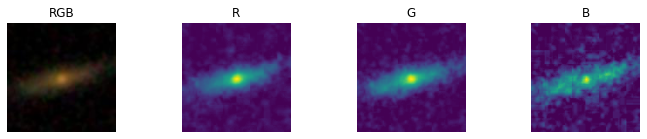

In [5]:
f, a = plt.subplots(1, 4, figsize=(12, 2))
plt.sca(a[0])
plt.imshow(images[42]), plt.title('RGB'), plt.axis('off')
for i in range(3):
    plt.sca(a[i+1])   
    plt.imshow(images[42][:, :, i]), plt.title('RGB'[i]), plt.axis('off')

## Prepare target labels

For training the model, prepare an array of n_samples x n_classes. Here we see the breakdown of number of samples per class in the dataset (which resemble that in the larget galaxy zoo dataset)

In [6]:
targ_labs = ['t_el', 't_cs', 't_dk']
targets = zoo_votes[targ_labs].to_numpy()

<BarContainer object of 3 artists>

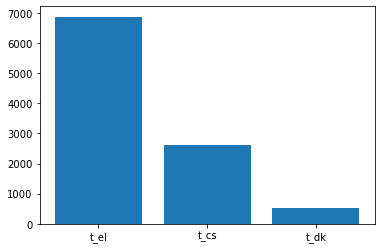

In [7]:
plt.bar(targ_labs, targets.sum(axis=0))

to convince ourselves that each object is only assigned to one category

In [8]:
targets.sum() == len(zoo_votes)

True

## Build model

We use tensorflow/keras to build a model based on an existing pretrained image classification network, and add layers to make compatible with the 3 class problem here.

In [9]:
res = tf.keras.applications.resnet.ResNet101(input_shape=(128, 128, 3), include_top=False)

171450368/171446536 [==============================] - 6s 0us/step


In [10]:
model = Sequential()
model.add(res)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(targets.shape[1], activation='softmax'))

In [11]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train the model
Here we show the devices available to tensorflow for training. On a GPU system, this will have devices tagged "GPU" in addition to the CPU devices.

Set aside a validation dataset to be used to evaluate performance of the model and show classification results

In [12]:
X_tr, X_te, Y_tr, Y_te = train_test_split(images, targets, test_size=0.33, random_state=42)

In [13]:
X_tr_in = tf.keras.applications.resnet.preprocess_input(np.copy(X_tr))
X_te_in = tf.keras.applications.resnet.preprocess_input(np.copy(X_te))

In [14]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]

In [15]:
tstart = time.time()
model.fit(X_tr_in, Y_tr, epochs=4, validation_data=(X_te_in, Y_te))
print(f'Total wall time: {time.time() - tstart:0.2f}')

Epoch 1/4
 20/210 [=>............................] - ETA: 3:03:20 - loss: 1.0066 - accuracy: 0.6828

KeyboardInterrupt: 

## Evaluate classification performance

using the test set we created earlier, make predictions and then plot the ROC curve showing the false positive and true positive rates as a function of classification threshold (e.g. label class X if P_x > threshold), for each of the classes separately.

In [ ]:
pred_te = model.predict(X_te_in)

In [ ]:
f, a = plt.subplots(1, 1, figsize = (12,7))
for i in range(targets.shape[1]):
    fpr, tpr, thresholds = roc_curve(Y_te[:, i], pred_te[:, i])
    auc_ = auc(fpr, tpr)
    plt.step(fpr, tpr, label=f'{targ_labs[i]} - AUC: {auc_:0.2f}')
plt.plot([0,1], [0,1], ls='--', c='k')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

Using `argmax` to identify the most-likely class, assign labels to the test data. The distribution of classes predicted in the test set looks similar to the overall dataset, with a bit larger share of spiral galaxies, but the trend largely holds

In [ ]:
pred_argmax_lab = label_binarize(pred_te.argmax(axis=1), classes=range(len(targ_labs)))
plt.bar(targ_labs, pred_argmax_lab.sum(axis=0))

## Preview the results

Finally, display some images predictions in each of the 3 classes. These predictions all look pretty good to the human eye, and it is fairly clear what constitutes unkown or ambiguous objects! A pretty good result for about 5 minutes of training!

In [ ]:
cand_el = np.where(pred_argmax_lab[:, 0])[0]
cand_cs = np.where(pred_argmax_lab[:, 1])[0]
cand_dk = np.where(pred_argmax_lab[:, 2])[0]

In [ ]:
f, a = plt.subplots(3, 5, figsize=[16, 8])
f.suptitle('predicted class associations')
for i in range(a.shape[1]):
    plt.sca(a[0][i])
    plt.imshow(X_te[cand_el[i]])
    i == 0 and plt.ylabel('eliptical')
for i in range(a.shape[1]):
    plt.sca(a[1][i])
    plt.imshow(X_te[cand_cs[i]])
    i == 0 and plt.ylabel('spiral')
for i in range(a.shape[1]):
    plt.sca(a[2][i])
    plt.imshow(X_te[cand_dk[i]])
    i == 0 and plt.ylabel('ambiguous')